### Basic Deep Learning Investigation of Features
##### Author: Alex Oesterling,


Todo:
* Tf idf, glove, base embedding
* Concatenate hidden state vectors

Class Imbalance:
* Weigh classes
* Remove backgorund
* Balanced sampling


In [1]:
from nltk.tokenize import word_tokenize, RegexpTokenizer
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Start by defining the file relative path of this dataset. 
file_name = "../../Data/practice_data.tsv"

# Read in the data, use unicode_escape in order to successfully encode the data. 
df = pd.read_csv(file_name, sep = "\t", encoding= 'unicode_escape')

In [3]:
#tokenize data

tokens = [word_tokenize(context) for context in df["citation_context"]]
for i, token in enumerate(tokens):
    tokens[i] = [word.lower() for word in token]

df["tokens"] = tokens

In [4]:
#assemble glove embeddings

glovepath = "../../Utilties/glove"
embeddings_dict = {}
with open(glovepath + "/glove.6B.50d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [5]:
#assemble naive frequency embeddings

tokenized_corpus = []
[tokenized_corpus.extend(token) for token in tokens]
fdist = nltk.FreqDist(tokenized_corpus)

sorted_keys = sorted(fdist.items(), key=lambda item: item[1])[::-1]
sorted_freqs = {k: v for k, v in sorted_keys}

vocab_to_int = {w:i+1 for i, w in enumerate(sorted_freqs)}
intwords = []

In [6]:
#Generate embeddings out of tokenized sentences
def embed_context(df, dictionary):
#     if embedding == "glove":
#         vector = []
#         for word in tokens:
#             if word in embeddings_dict:
#                 vector.append(embeddings_dict[word])
#         return np.array(vector)
    embedding = []
    for sentence in df["tokens"]:
        temp = []
        for word in sentence:
            if word in dictionary.keys():
                temp.append(dictionary[word])
        embedding.append(np.array(temp))
#         embedding.append([dictionary[word] for word in sentence])
    df["embeddings"] = embedding
#     print(embedding)

In [7]:
embed_context(df, embeddings_dict)
print(df["embeddings"])

0      [[0.70835, -0.57361, 0.15375, -0.63335, 0.4687...
1      [[0.418, 0.24968, -0.41242, 0.1217, 0.34527, -...
2      [[0.33042, 0.24995, -0.60874, 0.10923, 0.03637...
3      [[0.53074, 0.40117, -0.40785, 0.15444, 0.47782...
4      [[0.61183, -0.22072, -0.10898, -0.052967, 0.50...
                             ...                        
995    [[-1.5925, 0.75569, 1.4947, 0.11055, -0.05244,...
996    [[0.418, 0.24968, -0.41242, 0.1217, 0.34527, -...
997    [[0.09479, 0.44039, 0.23304, 1.3817, -0.1531, ...
998    [[0.418, 0.24968, -0.41242, 0.1217, 0.34527, -...
999    [[-1.5925, 0.75569, 1.4947, 0.11055, -0.05244,...
Name: embeddings, Length: 1000, dtype: object


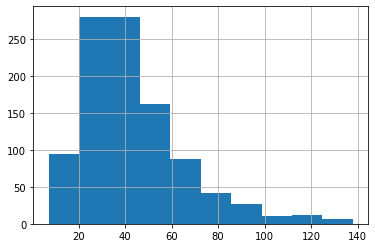

count    1000.00000
mean       43.59800
std        22.18988
min         7.00000
25%        28.00000
50%        39.00000
75%        55.00000
max       138.00000
dtype: float64

In [8]:
pd.Series([len(x) for x in df["embeddings"]]).hist()
plt.show()
pd.Series([len(x) for x in df["embeddings"]]).describe()

In [9]:
length = 138

padding = []

for i, sentence in enumerate(df["embeddings"]): 
    if len(sentence) <= length:
        zeroes = np.zeros((len(sentence[0]),length-len(sentence)))
        sent = np.transpose(np.array(sentence))
        padded = np.concatenate((zeroes,sent), axis=1)
    elif len(sentence) > length:
        padded = sentence[0:length]
    padding.append(padded)
    
df["padded"] = padding

print(df["padded"])

0      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
3      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
4      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
                             ...                        
995    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
996    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
997    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
998    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
999    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Name: padded, Length: 1000, dtype: object


In [10]:
ptrain = 0.80
pval = 0.10
ptest = 0.10

index_train = []
index_val = []
index_test = []

for clazz in df["citation_class_label"].unique():
    pd_filter = df.loc[df["citation_class_label"] == clazz]
    index_values = pd_filter.index.values
    np.random.shuffle(index_values)
    
    nitems = len(index_values)
    ix = 0
    index_train.extend(index_values[ix:ix+int(nitems*ptrain)])

    ix += int(nitems*ptrain)
    index_val.extend(index_values[ix:ix+int(nitems*pval)])

    ix += int(nitems*pval)
    index_test.extend(index_values[ix:ix+int(nitems*ptest)])

set_tag = ['test' if i in index_test else 'val' if i in index_val else 'train' for i in range(len(df))]   
df['set'] = set_tag
    
X_train = np.array(df["padded"].loc[df.set == 'train'].tolist())
X_val = np.array(df["padded"].loc[df.set == 'val'].tolist())
X_test = np.array(df["padded"].loc[df.set == 'test'].tolist())
y_train = df["citation_class_label"].loc[df.set == 'train'].values
y_val = df["citation_class_label"].loc[df.set == 'val'].values
y_test = df["citation_class_label"].loc[df.set == 'test'].values

<AxesSubplot:ylabel='Frequency'>

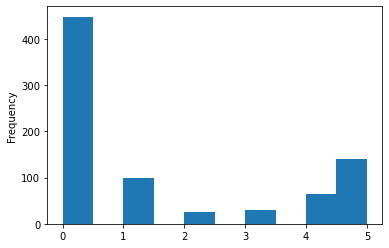

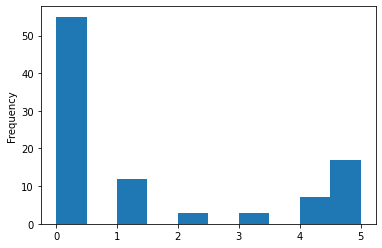

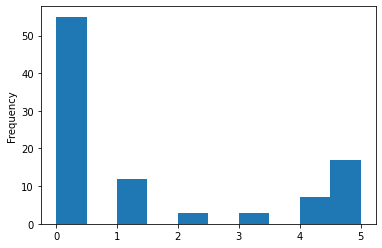

In [11]:
train = pd.Series(y_train)
plt.figure()
train.plot.hist()
val = pd.Series(y_val)
plt.figure()
val.plot.hist()
test = pd.Series(y_test)
plt.figure()
test.plot.hist()

In [26]:
import torch
from torch.utils.data import DataLoader, TensorDataset

train = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

batch_size = 64

train_dataloader = DataLoader(train, shuffle=True, batch_size = batch_size, drop_last=False)
val_dataloader = DataLoader(val, shuffle=True, batch_size = batch_size, drop_last=False)
test_dataloader = DataLoader(test, shuffle=True, batch_size = batch_size, drop_last=False)

In [36]:
import torch.nn as nn

class citationLSTM(nn.Module):
    
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
#         self.embedding = nn.Embedding(input_size, embedding_dim)
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, 
                            batch_first=True, bidirectional=True)
        
        # dropout layer
#         self.dropout = nn.Dropout(0.3)
        
        # linear and softmax layers
        self.fc = nn.Linear(hidden_dim*2, output_size)
        self.sig = nn.Softmax(dim=2)
#         self.sig = nn.Sigmoid()

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)
        # embeddings and lstm_out
#         embeds = self.embedding(x)

        lstm_out, hidden = self.lstm(x, hidden)
    
        # stack up lstm outputs TOOK FROM INTERNET, REMOVED BECAUSE WHY
#         lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        # dropout layer
#         out = self.dropout(lstm_out)

        #linear 
        out = self.fc(lstm_out)
        
        # softmax function
        sig_out = self.sig(out)
        print(sig_out.shape)
        sig_out = sig_out[:,-1, :] # get last timestep of labels

        # return last sigmoid output and hidden state
        return sig_out, hidden
        
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (torch.cuda.is_available()):
            hidden = (weight.new(self.n_layers*2, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers*2, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers*2, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers*2, batch_size, self.hidden_dim).zero_())
        
        return hidden

In [37]:
input_size = 138 #len(vocab_to_int)+1 # +1 for the 0 padding
output_size = 6
embedding_dim = 400
hidden_dim = 256
n_layers = 1

net = citationLSTM(input_size, output_size, hidden_dim, n_layers)

In [38]:
lr = 0.001
epochs = 16
DEVICE = "cuda:0"
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

if(torch.cuda.is_available()):
    print("Net GPU")
    net.to(DEVICE)
    
net.train()

counter = 0
print_every = 100
for e in range(epochs):
    
    for data, labels in train_dataloader:
        h = net.init_hidden(data.shape[0])

        counter += 1
        
        if(torch.cuda.is_available()):
            data = data.to(DEVICE)
            labels = labels.to(DEVICE)
            data = data.type(torch.FloatTensor).to(DEVICE)

        else:
            data = data.type(torch.FloatTensor)

        h = tuple([each.data for each in h])
        
        net.zero_grad()
        
        
        output, h = net(data, h)
        loss = criterion(output.float(), labels.long())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
#         nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
#             val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for data, labels in val_dataloader:
                val_h = net.init_hidden(data.shape[0])

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                if(torch.cuda.is_available()):
                    data, labels = data.to(DEVICE), labels.to(DEVICE)
                    data = data.type(torch.FloatTensor).to(DEVICE)
                else:
                    data = data.type(torch.FloatTensor)
                
                output, val_h = net(data, val_h)
                val_loss = criterion(output.float(), labels.long())

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

Net GPU
torch.Size([64, 50, 6])
torch.Size([64, 50, 6])
torch.Size([64, 50, 6])
torch.Size([64, 50, 6])
torch.Size([64, 50, 6])
torch.Size([64, 50, 6])
torch.Size([64, 50, 6])
torch.Size([64, 50, 6])
torch.Size([64, 50, 6])
torch.Size([64, 50, 6])
torch.Size([64, 50, 6])
torch.Size([64, 50, 6])
torch.Size([38, 50, 6])
torch.Size([64, 50, 6])
torch.Size([64, 50, 6])
torch.Size([64, 50, 6])
torch.Size([64, 50, 6])
torch.Size([64, 50, 6])
torch.Size([64, 50, 6])
torch.Size([64, 50, 6])
torch.Size([64, 50, 6])
torch.Size([64, 50, 6])
torch.Size([64, 50, 6])
torch.Size([64, 50, 6])
torch.Size([64, 50, 6])
torch.Size([38, 50, 6])
torch.Size([64, 50, 6])
torch.Size([64, 50, 6])
torch.Size([64, 50, 6])
torch.Size([64, 50, 6])
torch.Size([64, 50, 6])
torch.Size([64, 50, 6])
torch.Size([64, 50, 6])
torch.Size([64, 50, 6])
torch.Size([64, 50, 6])
torch.Size([64, 50, 6])
torch.Size([64, 50, 6])
torch.Size([64, 50, 6])
torch.Size([38, 50, 6])
torch.Size([64, 50, 6])
torch.Size([64, 50, 6])
torch.Si

In [39]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0



# init hidden state


net.eval()
# iterate over test data
    
y_pred = []
for data, labels in test_dataloader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = net.init_hidden(data.shape[0])
    h = tuple([each.data for each in h])

    if(torch.cuda.is_available()):
        data, labels = data.to(DEVICE), labels.to(DEVICE)
        data = data.type(torch.FloatTensor).to(DEVICE)
    else:
        data = data.type(torch.FloatTensor)

    # get predicted outputs
    output, h = net(data, h)
    y_pred.extend(list(output.cpu().detach().numpy()))
    # calculate loss
    test_loss = criterion(output.float(), labels.long())
    test_losses.append(test_loss.item())

#     # convert output probabilities to predicted class (0 or 1)
#     pred = torch.round(output.squeeze())  # rounds to the nearest integer
#     # compare predictions to true label
#     correct_tensor = pred.eq(labels.float().view_as(pred))
#     correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
#     num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
# test_acc = num_correct/len(test_loader.dataset)
# print("Test accuracy: {:.3f}".format(test_acc))
print([sum(y_pred[j]) for j in range(len(y_pred))])

torch.Size([64, 50, 6])
torch.Size([33, 50, 6])
Test loss: 1.467
[0.9999999181251837, 0.9999999775679953, 1.0000000417735464, 0.9999999736319296, 0.9999999388694505, 0.9999999999481588, 0.9999998653834155, 1.0000000551083303, 0.9999999646456672, 0.9999999904057404, 1.0000000758991519, 1.0000000994441507, 0.9999999870408374, 1.0000000384550276, 1.000000033005108, 1.000000042237616, 1.0000000563488811, 0.999999955626663, 0.9999999220460722, 1.0000000586478563, 0.9999999100141963, 0.9999999731842308, 1.0000000808834102, 1.000000062873596, 1.0000001303092176, 0.9999998619298367, 1.000000085858801, 1.0000000838497272, 0.9999999895987912, 0.9999998579839939, 1.0000000237705535, 0.9999999839667453, 0.9999999924036729, 1.0000000122320216, 0.9999999881359827, 1.0000000064330834, 0.9999999030294475, 1.0000001155456175, 1.0000000924374035, 0.9999999335368557, 1.0000000743978035, 0.9999999939996087, 1.0000000134575657, 1.0000000713614554, 0.9999999616577497, 1.0000000047443223, 1.0000000285031092,

In [40]:
print(np.array(y_pred).shape)
print(y_test.shape)

(97, 6)
(97,)


In [41]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score

print(len(y_pred))

fpr = dict()
tpr = dict()
roc_auc = dict()
f1s = []
for i in range(6):
    tests = np.array(y_test[:len(y_pred)] == i, dtype="int")
    scores = [y_pred[j][i] for j in range(len(y_pred))]
    preds = np.array([np.argmax(y_pred[j]) == i for j in range(len(y_pred))], dtype="int")
    fpr[i], tpr[i], thresholds = roc_curve(tests, scores)
    roc_auc[i] = auc(fpr[i], tpr[i])
    print("Class {}".format(i+1))
    print(tests)
    print(preds)
    f1s.append(f1_score(tests, preds))

97
Class 1
[1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 0 1 0 0 1 0 1 0 0 1 0 0 1 1 1 0 1 1 0
 1 0 0 0 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 0
 0 0 1 1 0 1 1 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Class 2
[0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Class 3
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 

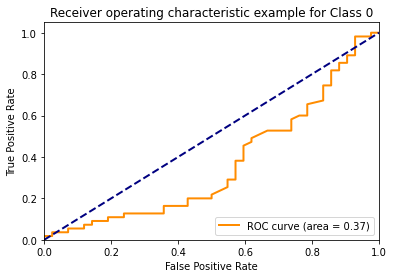

F1 Score: 0.7236842105263158


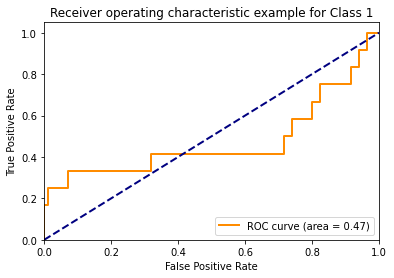

F1 Score: 0.0


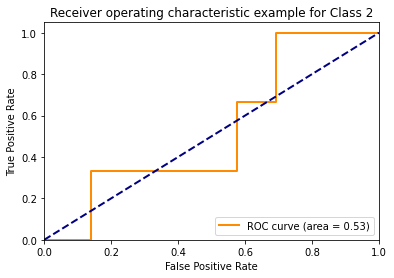

F1 Score: 0.0


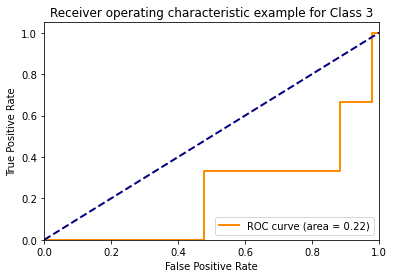

F1 Score: 0.0


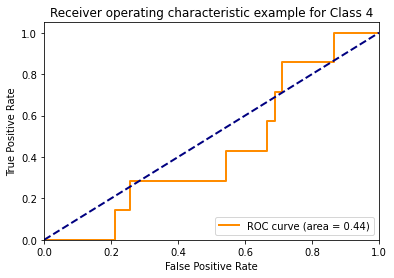

F1 Score: 0.0


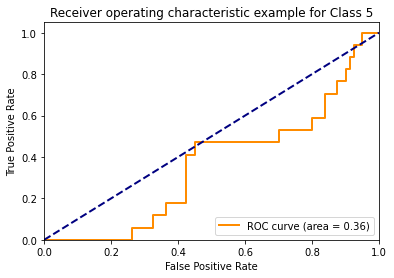

F1 Score: 0.0


In [43]:
for i in range(6):
    plt.figure()
    lw = 2
    plt.plot(fpr[i], tpr[i], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example for Class {}'.format(i))
    plt.legend(loc="lower right")
    plt.show()
    print("F1 Score: {}".format(f1s[i]))

In [44]:
for i in range(6):
    tests = y_test[:len(y_pred)] == i
    preds = [y_pred[j][i] for j in range(len(y_pred))]
    print(y_test[:len(y_pred)] == i)
    print([y_pred[j][i] for j in range(len(y_pred))])

[ True  True False  True  True  True  True  True False  True  True  True
  True False  True  True False False False  True False False  True False
  True False False  True False False  True  True  True False  True  True
 False  True False False False  True  True  True  True  True False False
  True False  True  True  True  True  True  True False False  True  True
  True  True  True  True  True False False  True  True  True  True False
 False False False False  True  True False  True  True  True False False
 False  True False False False False  True  True False False False False
  True]
[0.9999893, 0.9999505, 0.9999502, 0.9999629, 0.99994874, 0.99994326, 0.9999548, 0.9999547, 0.9999418, 0.99995637, 0.9999666, 0.9999583, 0.99996257, 0.9999542, 0.9999614, 0.99995863, 0.9999584, 0.99995995, 0.9999559, 0.9999597, 0.9999858, 0.99997973, 0.9999633, 0.99996316, 0.99993706, 0.9999634, 0.9999629, 0.99998057, 0.99998105, 0.99996984, 0.9999757, 0.999944, 0.999949, 0.99995863, 0.99997485, 0.9999609,